# Hierarchical Approaches

When we face problems with high complexity like doing routing over a graph of continent with millions of nodes, surely we won't do Dijkstra or Depth First Search. We resort to do pruning of the search space and some precomputations that we can have stored on our servers, so when the user's query arrives we are ready for it.

Hierarchical search algorithms prune the search space by generating admissible heuristic that abstracts the search space and thus pruning it. Read more about the general approach of hierarchical methods at [Faster Optimal and Suboptimal Hierarchical Search](https://www.aaai.org/ocs/index.php/SOCS/SOCS11/paper/viewFile/4035/4363).

We will now talk about two hierarchical approaches that solves the shortest path problem and how their heuristics are computed and after that we will be implementing contraction hierarchies algorithm.



## Highway Hierarchies

It was described at [Highway Hierarchies Hasten Exact Shortest Path Queries - ESA 2005](https://link.springer.com/chapter/10.1007/11561071_51).  

We compute hierarchy level for each **arc**/road in the graph to distinguish residential roads and national roads and highways and with some data about the arcs like the max speed and # of turns in the road would affect this distinction. After computing the heuristic function we run bi-directional Dijkstra/(or any type of search method) and as we run the algorithm we consider the level/heuristic value of the arcs when we expand a certain node like if we are very far away from our destination we only consider highways and if we are closer we look at national roads and if we are really close we traverse residential roads.  

That is the pruning we talked about at the beginning, and the algorithm makes sense because if you are living at the side of the highway and want to go some place close to your place on the same side of where your at, you won't take the highway and would prefer going through resdential roads, despite the fact that the highway is *faster*.  

---

## Contraction Hierarchies

As you saw that the highway hierarchies algorithm gives us back 3 level/hierarchies (residential roads/ national roads/ highways) and that is how it prunes the search space and abstracts it into 3 choices. Contraction hierarchies introduced at [Contraction Hierarchies: Faster and Simpler Hierarchical Routing in Road Networks](https://link.springer.com/chapter/10.1007/978-3-540-68552-4_24) gives us more levels of hierarchies (depends on the size of the graph) for each node based on when the node was *contracted*. The level of the node is its order of contraction relative to other nodes in the graph, and all the nodes in the graph are to be contracted eventually. Accordingly, the number of levels/hierarchies that the heuristic generates is equal to the number of nodes in the graph which is a good thing because the more hierarchies we have, the more we are pruning the search space.  

We won't get into the correctness proof of the algorithm, for that check the paper. If you are familiar with correctness proof of graph search algorithms, you will find it super straightforward.  

### Contraction

Take a node out from the graph and its adjacent edges and add new edges to the graph to keep the shortest path between all pairs of the rest of the nodes in the graph the same as if the node was still in the graph, that will produce another graph without the deleted node and its adjacent edges but with possible new added edges so you take another node out and its adjacent edges and add the necessary arcs. You keep going untill you contracted/deleted all nodes of the graph.

The new graph that would be used in the algorithm is the original graph with all the arcs that were added to keep the shortest path invariant through the process of contraction of all the nodes.

We compute the level of a node as its order of contraction, so the available levels are equal to the number of nodes in the graph; from 1 to n.

#### What order of contraction to the nodes should I follow?

Any order will make the algorithm runs successfuly, but some orders will shorten the time of contraction and minimizes the number of arcs addes to the graph. 

We will see one in the implementation below.

### Dijkstra

So after contraction we have a graph with nodes labeled with some level. We do dijkstra from the source and dijkstra from the destination.  

The point of these two dijkstra is not about finding the destination, but to find the shortest path between the source and all the other nodes in the graph, but here is the catch:

We have a restriction over the dijkstra from the source and the dijkstra from the destionation.  

* The dijkstra from the source only considers arcs _u_, _v_ where level(_u_) > level(_v_) so you only want to relax node with a higher level than the node you have relaxed at that iteration. This is called the **upward graph**.  

* The dijkstra from the destination only considers arcs _u_, _v_ where level(_u_) < level(_v_) so you only want to relax node with a lower level than the node you have relaxed at that iteration. This is called the **downward graph**

That is the pruning we talked about.  

At the end you see the common nodes that have been relaxed from both (downward/upward) graphs and connect them and which would probably result into multiple paths between source and destination, so you choose the shortest path of these possible paths and return it.

In [1]:
import networkx as nx
import random
import math

In [118]:
G = nx.Graph()

When you do contraction to compute the levels of the node, you need to produce new graph every time to do the next contraction. But that would be a lot of memory so you would just have a flag on every node that eliminates that node and its adjacent edges from the graph when contracted.

In [119]:
G.add_node(1,contracted=False)
G.add_node(2,contracted=False)
G.add_node(3,contracted=False)
G.add_node(4,contracted=False)
G.add_node(5,contracted=False)
G.add_node(6,contracted=False)
G.add_node(7,contracted=False)
G.add_node(8,contracted=False)
G.add_node(9,contracted=False)
G.add_node(10,contracted=False)
G.add_node(11,contracted=False)
G.add_node(12,contracted=False)
G.add_node(13,contracted=False)
G.add_node(14,contracted=False)

In [120]:
edges = [
    (1,2,{'weight':1}),
    (1,3,{'weight':4}),
    (1,7,{'weight':7}),
    (2,3,{'weight':5}),
    (2,4,{'weight':2}),
    (3,4,{'weight':2}),
    (3,6,{'weight':1}),
    (3,7,{'weight':2}),
    (3,8,{'weight':1}),
    (3,9,{'weight':1}),
    (4,5,{'weight':5}),
    (5,10,{'weight':7}),
    (6,7,{'weight':4}),
    (6,8,{'weight':3}),
    (6,10,{'weight':3}),
    (6,5,{'weight':3}),
    (6,9,{'weight':1}),
    (7,8,{'weight':6}),
    (8,9,{'weight':3}),
    (8,13,{'weight':5}),
    (9,12,{'weight':1}),
    (9,10,{'weight':3}),
    (10,11,{'weight':4}),
    (11,12,{'weight':3}),
    (11,13,{'weight':4}),
    (12,13,{'weight':2}),
    (14,1,{'weight':3}),
    (14,13,{'weight':2})
]

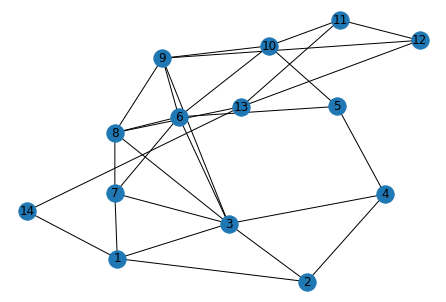

In [121]:
G.add_edges_from([*edges])
nx.draw(G,with_labels=True)

This is the normal dijkstra search to compute the shortest path between node `source` and `destination` if `contracted` flag is turned off.  

If not, we give the `contracted` variable the number of the node that we want to contract and the algorithm computes the shortest path between the nodes accordingly.  

Please note that we need to turn off the flag at the end of the function because the graph variable is passed by reference.

In [132]:
def dijkstra_with_contraction(G, source, destination, contracted = None):
    nx.set_node_attributes(G, {contracted: True}, 'contracted')
        
    shortest_path = dict()
    heap = list()
    
    for i in G.nodes():
        if not nx.get_node_attributes(G, 'contracted')[i]:
            shortest_path[i] = math.inf
            heap.append(i)
    shortest_path[source] = 0
    
    while len(heap) > 0:
        
        q = min(heap, key = lambda node : shortest_path[node])
        if q == destination:
            nx.set_node_attributes(G, {contracted: False}, 'contracted')
            return shortest_path[q]
        heap.remove(q)
        
        for v in G[q]:
            # if the node is contracted we skip it
            if not nx.get_node_attributes(G, 'contracted')[v]:
                distance = shortest_path[q] + G[q][v]['weight']
                if distance < shortest_path[v]:
                    shortest_path[v] = distance
                    
    nx.set_node_attributes(G, {contracted: False}, 'contracted')
    
    return math.inf # if we can't reach the destination

Computing the shortest path between every pair of nodes in the graph without any contraction. These values should be preserved through the contraction procedures.  

Of course we can use networkx here instead like [`nx.all_pairs_shortest_path`](https://networkx.github.io/documentation/stable/reference/algorithms/generated/networkx.algorithms.shortest_paths.unweighted.all_pairs_shortest_path.html#networkx.algorithms.shortest_paths.unweighted.all_pairs_shortest_path).

In [124]:
shortest_paths = dict()
for i in G.nodes():
    # dictionary for every node
    shortest_paths[i] = dict()
    for j in G.nodes():
        # that will be filled with the shortest path
        # between it and other nodes
        shortest_paths[i][j] = dijkstra_with_contraction(G, i, j)

In [125]:
shortest_paths

{1: {1: 0,
  2: 1,
  3: 4,
  4: 3,
  5: 8,
  6: 5,
  7: 6,
  8: 5,
  9: 5,
  10: 8,
  11: 9,
  12: 6,
  13: 5,
  14: 3},
 2: {1: 1,
  2: 0,
  3: 4,
  4: 2,
  5: 7,
  6: 5,
  7: 6,
  8: 5,
  9: 5,
  10: 8,
  11: 9,
  12: 6,
  13: 6,
  14: 4},
 3: {1: 4,
  2: 4,
  3: 0,
  4: 2,
  5: 4,
  6: 1,
  7: 2,
  8: 1,
  9: 1,
  10: 4,
  11: 5,
  12: 2,
  13: 4,
  14: 6},
 4: {1: 3,
  2: 2,
  3: 2,
  4: 0,
  5: 5,
  6: 3,
  7: 4,
  8: 3,
  9: 3,
  10: 6,
  11: 7,
  12: 4,
  13: 6,
  14: 6},
 5: {1: 8,
  2: 7,
  3: 4,
  4: 5,
  5: 0,
  6: 3,
  7: 6,
  8: 5,
  9: 4,
  10: 6,
  11: 8,
  12: 5,
  13: 7,
  14: 9},
 6: {1: 5,
  2: 5,
  3: 1,
  4: 3,
  5: 3,
  6: 0,
  7: 3,
  8: 2,
  9: 1,
  10: 3,
  11: 5,
  12: 2,
  13: 4,
  14: 6},
 7: {1: 6,
  2: 6,
  3: 2,
  4: 4,
  5: 6,
  6: 3,
  7: 0,
  8: 3,
  9: 3,
  10: 6,
  11: 7,
  12: 4,
  13: 6,
  14: 8},
 8: {1: 5,
  2: 5,
  3: 1,
  4: 3,
  5: 5,
  6: 2,
  7: 3,
  8: 0,
  9: 2,
  10: 5,
  11: 6,
  12: 3,
  13: 5,
  14: 7},
 9: {1: 5,
  2: 5,
  3: 1,
  4: 

## How to choose the order of contraction

By calculating the edge difference of the nodes which equals to $S - E$; $S$ is number of the added arcs to the graph if that node is contracted and $E$ is the number of adjacent edges to the node that would be deleted if the node is contracted.

We want to contract the nodes in an ascending order of their edge difference values because if these nodes contracted first we will have to add a little number of arcs to the original graph in subsequent contractions.  

If the number of $S$ is lower than $E$, that means when contracted we won't add as many edges to the graph as we have deleted already, SO when we contract later nodes we will have more pruned graph and we would have to add less and less arcs in subsequent contractions.  

Think about it yourself, you will find that the nodes with the lowest ED are on "edge" of the graph not central nodes, which leads to small number of arcs to be added after contracting them and when we get to the contraction of central nodes we have already contracted most of the nodes of the graph so we don't need to add as many arcs as we would have added if these central nodes have been contracted before "edge" nodes.   

# Calculating ED

In [133]:
def calculate_edge_difference(G, shortest_paths):
    edge_difference = list()
    seenBefore = list()
    
    for i in G.nodes():
        # used in edge difference calculations
        edges_incident = len(G[i])

        # we will be deleting the node entry
        # from the original shortest paths
        # dictionary so we need to save its state
        # for later iterations
        contracted_node_paths = shortest_paths[i]
        del shortest_paths[i]
        
        # excluding the node that we have just contracted
        new_graph = [*G.nodes()] 
        new_graph.remove(i)
        
        # let's compute the new shortest paths between
        # the nodes of the graph without the contracted
        # node so we can see the changes and add arcs 
        # to the graph accordingly but that is in
        # the algorithm itself 
        new_shortest_paths = dict()

        for source in new_graph:
            new_shortest_paths[source] = dict()
            for destination in new_graph:
                # path the contracted node "i" to compute new shortest paths accordingly
                new_shortest_paths[source][destination] = dijkstra_with_contraction(G, \
                                                                                    source, \
                                                                                    destination, \
                                                                                    contracted = i)
        # the add arcs to keep the graph all pairs shortest paths invariant
        shortcuts = 0

        for source in new_shortest_paths:
            # we get a copy from the original and the new shortest paths dictionary
            SP_contracted = new_shortest_paths[source]
            SP_original = shortest_paths[source]
            for destination in SP_contracted:
                # this is statement so we don't add 2 arcs
                # for the same pair of nodes 
                if [source, destination] in seenBefore: continue
                seenBefore.append(sorted((source,destination)))
                
                # if there is a difference between the original SP and
                # post-contraction SP -- just add new arc
                if SP_contracted[destination] != SP_original[destination]:
                    shortcuts += 1
        
        # let's leave the dictionary as we took it 
        # from the last iteration
        shortest_paths[i] = contracted_node_paths
        
        # this is the value of the contraction
        # heuristic for that node
        ED = shortcuts - edges_incident
        edge_difference.append((i, ED))
    return edge_difference

In [134]:
edge_difference = calculate_edge_difference(G, shortest_paths)

In [138]:
# sort by the ED heuristic value
# so we can contract them in the same
# order as in this list
edge_difference.sort(key = lambda pair : pair[1])
edge_difference

[(8, -5),
 (7, -4),
 (10, -4),
 (5, -3),
 (11, -3),
 (2, 0),
 (14, 0),
 (1, 2),
 (6, 3),
 (13, 5),
 (4, 6),
 (12, 18),
 (9, 22),
 (3, 29)]

We have now computed the ED value for each node when it is the only node contracted in the graph, but in the algorithm itself we contract the nodes successively so these values we have generated won't be valid and reflecting the then current state of the graph possibly after the first iteration of the algorithm.

But as you remember from the introduction, that any arbitrary order of nodes contraction is valid and will lead to the correct answer eventually.

We could update the edge difference list at each iteration, which would be expensive for large graphs or select some nodes to update their ED value like the adjacent nodes of the current contracted node. After re-ordering the list of the node we continue our algorithm. There is a number of heuristics that update the order of contraction in the paper introducing the algorithm.

---

We will contract nodes according to the order of edge_difference list which would give us good enough preformance for the current problem.

In [140]:
# to keep track of the edges added after the algorithm finishes
edges_before = [*G.edges()]

In [141]:
current_graph = [*G.nodes()]

# iterating over the tuples (node, level)
# from the sorted edge difference list

for node_ED in edge_difference:
    node = node_ED[0]
    
    # now we will contract the given node through all iterations
    nx.set_node_attributes(G, {node: True}, 'contracted')
    
    # we have already contracted the node
    # so there is no need 
    new_graph = current_graph
    new_graph.remove(node)
    current_shortest_paths = dict()
    for source in new_graph:
            current_shortest_paths[source] = dict()
            for destination in new_graph:
                current_shortest_paths[source][destination] = dijkstra_with_contraction(G, \
                                                                                    source, \
                                                                                    destination)
                
    for source in current_shortest_paths:
        SP_contracted = current_shortest_paths[source]
        SP_original = shortest_paths[source]
        for destination in SP_contracted:
            if source == destination: continue
            if SP_contracted[destination] != SP_original[destination]:
                print("we have added edge between ", source, destination," after contracting", node)
                
                # it seems like we add two edges instead of one, but this is simple graph
                # so adding edge from a to b and then adding edge from b to a are the same
                # doesn't add a thing, we didn't include condition for that because it will
                # complicate the algorithm
                
                G.add_edge(source, destination, weight=SP_original[destination])
                
    
    current_graph = new_graph

we have added edge between  1 4  after contracting 2
we have added edge between  4 1  after contracting 2
we have added edge between  4 14  after contracting 2
we have added edge between  14 4  after contracting 2
we have added edge between  1 13  after contracting 14
we have added edge between  13 1  after contracting 14


---
new edges set after adding the additional arcs

In [142]:
edges_after = [*G.edges()]

In [145]:
print("# edges before", len(edges_before))
print("# edges after", len(edges_after))

# edges before 28
# edges after 31


Let's see what are these edges

In [148]:
added_edges = list(set(edges_after) - set(edges_before))
added_edges

[(1, 13), (4, 14), (1, 4)]

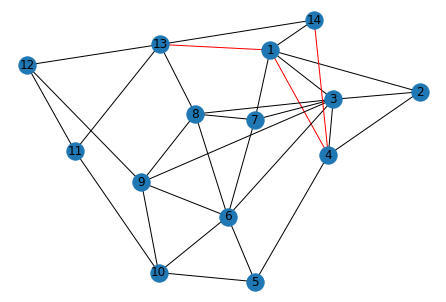

In [158]:
# let's color these edges and draw the graph again
colors = ['r' if edge in added_edges else 'k' for edge in G.edges()] 
nx.draw(G, with_labels=True, edge_color=colors)

After we have added the new edges we need to do dijkstra from source and dijkstra from destination, according to the **upward** and **downward** graph policy we talked about in the introduction.

In [163]:
# which is the same as edge_difference
# list because we didn't use any update heuristic
hierarchical_order = dict()
for order, node in enumerate(edge_difference):
    hierarchical_order[node[0]] = order

dictionary of nodes and its level of hierarchy

In [164]:
hierarchical_order

{8: 0,
 7: 1,
 10: 2,
 5: 3,
 11: 4,
 2: 5,
 14: 6,
 1: 7,
 6: 8,
 13: 9,
 4: 10,
 12: 11,
 9: 12,
 3: 13}

let's solve our problem with source node to be 8 and target node to be 12

In [320]:
source = 8
destination = 12

# Dijkstra From Source

**upward graph**

We will do the normal dijkstra algorithm with our origin to be $8$ but with one restriction, that we don't visit children of the relaxed node with lower level of hierarchy than their parent.  

So if we have relaxed node number $13$ we can't relax the edge between node $13$ and node $11$ because the level of node $13$ is higher.  

This is the pruning we talked about and it gave us the correct answer at the end.

In [334]:
dist_s = dict()
parent_s = dict()
heap_s = list()
for i in G.nodes():
    dist_s[i] = math.inf
    parent_s[i] = None
    heap_s.append(i)
dist_s[source] = 0

# we will need this flag to know when
# to stop the search if we got stuck
# because of hierarchical ordering

stuck = False

while not stuck:
    stuck = True
    min_node = min(heap_s, key = lambda node : dist_s[node])
    heap_s.remove(min_node)
    order_parent = hierarchical_order[min_node]
    for child in G[min_node]:
        order_child = hierarchical_order[child]
        if order_child < order_parent: continue
        stuck = False
        distance = dist_s[min_node] + G[min_node][child]['weight']
        if distance < dist_s[child]:
            dist_s[child] = distance
            parent_s[child] = min_node

Relaxed nodes are given a destination, if we can't reach a node because of its level we give it infinity.

In [335]:
dist_s

{1: inf,
 2: inf,
 3: 1,
 4: inf,
 5: inf,
 6: 3,
 7: 6,
 8: 0,
 9: 3,
 10: inf,
 11: inf,
 12: inf,
 13: 5,
 14: inf}

# Dijkstra From Target

**downward graph**

Same idea as upward graph dijkstra but you don't relax an edge between a parent and child with higher hierarchy.

In [336]:
dist_f = dict()
parent_f = dict()
heap_f = list()
for i in G.nodes():
    dist_f[i] = math.inf
    parent_f[i] = None
    heap_f.append(i)
dist_f[destination] = 0


stuck = False

while not stuck:
    stuck = True
    min_node = min(heap_f, key = lambda node : dist_f[node])
    heap_f.remove(min_node)
    order_parent = hierarchical_order[min_node]
    for child in G[min_node]:
        order_child = hierarchical_order[child]
        if order_child < order_parent: continue
        stuck = False
        distance = dist_f[min_node] + G[min_node][child]['weight']
        if distance < dist_f[child]:
            dist_f[child] = distance
            parent_f[child] = min_node

In [337]:
dist_f

{1: inf,
 2: inf,
 3: 2,
 4: inf,
 5: inf,
 6: inf,
 7: inf,
 8: inf,
 9: 1,
 10: inf,
 11: inf,
 12: 0,
 13: inf,
 14: inf}

We need to merge the common settled nodes from both `SP_d` and `SP_s` and see the minimum summation of value and that is our shortest path like in bi-directional search and collusion between front expansion and back expansion.

In [338]:
minimum = math.inf
merge_node = None
for i in dist_s:
    if dist_f[i] == math.inf: continue
    if dist_f[i] + dist_s[i] < minimum:
        minimum = dist_f[i] + dist_s[i]
        merge_node = i

In [339]:
minimum

3

In [340]:
merge_node

3

very small utility to see the route from origin of dijkstra to a given node

In [341]:
def route_dijkstra(parent, node):
    route = []
    while node != None:
        route.append(node)
        node = parent[node]
    return route[::-1]

In [342]:
route_from_target = route_dijkstra(parent_f, merge_node)
route_from_target

[12, 9, 3]

In [343]:
route_from_source = route_dijkstra(parent_s, merge_node)
route_from_source

[8, 3]

In [344]:
route = route_from_source + route_from_target[::-1][1:]
route

[8, 3, 9, 12]

let's use networkx algorithm to see if that is true or not 

In [345]:
from networkx.algorithms.shortest_paths.weighted import single_source_dijkstra

In [346]:
single_source_dijkstra(G, source, destination)

(3, [8, 3, 9, 12])